# DATA2901 Assignment Data Workflow - ADV02 Group 10 

## Python/SQL Setup

In [41]:
from sqlalchemy import create_engine, inspect
from sqlalchemy import text 
import psycopg2
import psycopg2.extras
import json
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import geoalchemy2
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
import json
import re
import time as t
import random 
import seaborn as sns

# Helper methods for connecting to and querying postgres server
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        
        # Making schema selection easier 
        if db_schema != "public" and db != None and conn != None:
            try:
                # IF THIS DOESNT WORK FOR CHRIS OR LUKA, REMOVE THE TEXT() WRAPPER
                conn.execute(text("set search_path to " + db_schema))
                print("Search path set to " + db_schema)
            except Exception as e:
                print("Unable to set search path to "+ db_schema)
                print(e)
                pgdisconnect(db, conn)
                
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    # conn = database connection object, sqlcmd = string holding command
    result = pd.DataFrame() if df else None
    sqlcmd = text(sqlcmd)
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

''' in case the text() causes issues down the line
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
'''

# Creates WKT elements and if encountered, converts polygons to multipolygons
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return geoalchemy2.WKTElement(geom.wkt, srid)

# Disconnects from server, able to commit changes here
def pgdisconnect(db, conn, commit=False):
    try:
        if commit:
            conn.commit()
            print("Changes committed.")
        conn.close()
        db.dispose()
        print("Disconnected from database.")
        return True
    except Exception as E:
        print("Unable to disconnect from the database.")
        print(e)
        return False

# Utilises disconnect + reconnect methods, best for unique servers like Yash's where you must commit or no change is saved
def pgreconnect(credentials, old_db, old_conn, db_schema="public", commit=False):
    if pgdisconnect(old_db, old_conn, commit):
        return pgconnect(credentials, db_schema)
    else:
        print("No new connection made.")
        return None, None

In [42]:
# Connecting to database
credentials = "Credentials.json"
db, conn = pgconnect(credentials, 'sa2')

Connected successfully.
Search path set to sa2


In [3]:
# Creating new schema to store all tables created
sql = """
CREATE SCHEMA IF NOT EXISTS sa2;
SET search_path TO sa2;
"""

conn.execute(text(sql))

In [4]:
# Adding PostGIS to sa2 schema
sql = """
CREATE EXTENSION IF NOT EXISTS postgis;

UPDATE pg_extension
SET extrelocatable = TRUE
WHERE extname = 'postgis';

ALTER EXTENSION postgis
SET SCHEMA sa2;
"""

conn.execute(text(sql))
query(conn, "SELECT PostGIS_version()") 

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [5]:
#db, conn = pgreconnect(credentials, db, conn, 'sa2', True)
#query(conn, "SET SEARCH_PATH TO sa2")

## Task 1: Cleaning & Importing Datasets

### SA2 Regions dataset
The regions dataset provides basic information on the level 2 statistical areas (SA2) that divide Australia into communities of approximately 10000 people.
Originating from the ABS, the table includes the name of each SA2 region as well as its geographical location and area, allowing it to act as the central table for all other tables to perform joins with it.

The regions dataset is provided as a shapefile, and so can be loaded directly into geopandas:

In [6]:
# Loading and inspecting the dataset
path = "SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp"
regions = gpd.read_file(path)
print(regions.shape)
print(regions.columns)
print(regions.dtypes)
regions.head()

(2473, 17)
Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')
SA2_CODE21      object
SA2_NAME21      object
CHG_FLAG21      object
CHG_LBL21       object
SA3_CODE21      object
SA3_NAME21      object
SA4_CODE21      object
SA4_NAME21      object
GCC_CODE21      object
GCC_NAME21      object
STE_CODE21      object
STE_NAME21      object
AUS_CODE21      object
AUS_NAME21      object
AREASQKM21     float64
LOCI_URI21      object
geometry      geometry
dtype: object


,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."


For this analysis, we are only interested in the SA2 regions within greater Sydney. We will filter for only these particular regions here:

In [7]:
# Filter for only the SA2 regions in greater Sydney
regions = regions[regions["GCC_CODE21"] == "1GSYD"]

We will also clean the table, removing all other unnecessary columns:

In [8]:
# Removing unnecessary columns
to_remove = ["CHG_FLAG21", "CHG_LBL21", "GCC_CODE21", "GCC_NAME21", "STE_CODE21", "STE_NAME21", "AUS_CODE21", "AUS_NAME21", "LOCI_URI21"]
regions.drop(to_remove, axis=1, inplace=True)

Given that some regions are provided as a POLYGON while others are a MULTIPOLYGON, we will need to convert them all to the same datatype:

In [9]:
# Converting all POLYGON types to MULTIPOLYGON
regions["geom"] = regions["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=7844))
regions.drop(columns="geometry", inplace=True)

In [10]:
# Renaming columns
regions.rename({
    "SA2_CODE21":"sa2_code",
    "SA2_NAME21":"sa2_name",
    "SA3_CODE21":"sa3_code",
    "SA3_NAME21":"sa3_name",
    "SA4_CODE21":"sa4_code",
    "SA4_NAME21":"sa4_name",
    "AREASQKM21":"area_sqkm",
    "geom":"geometry"
}, axis=1, inplace=True)

# Correcting datatypes
regions = regions.astype({"sa2_code":"int64", "sa3_code":"int64", "sa4_code":"int64"})

In [11]:
# Inspecting the dataset after modifcation
regions.head()

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry
28,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...


Finally, we will add the DataFrame to the database:

In [12]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS regions CASCADE;
CREATE TABLE regions (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(100) UNIQUE NOT NULL,
    sa3_code INTEGER NOT NULL,
    sa3_name VARCHAR(100) NOT NULL,
    sa4_code INTEGER NOT NULL,
    sa4_name VARCHAR(100) NOT NULL,
    area_sqkm NUMERIC NOT NULL,
    geometry GEOMETRY(MULTIPOLYGON, 7844) NOT NULL
);"""
conn.execute(text(sql));

regions.to_sql(name="regions", con=conn, schema="sa2", if_exists="append", index=False,
              dtype={'geometry': geoalchemy2.Geometry('MULTIPOLYGON', 7844)})

query(conn, "SELECT * FROM regions LIMIT 5;")

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry
0,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...
2,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...
3,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...
4,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...


### Business dataset
The business dataset comes from the ABS once again and provides us with the counts of each type of business (including health and retail businesses as required in our analysis), and further partitioned by their annual turnover. For the analysis section, this table will help us in calculating both the $z_{retail}$ and $z_{health}$ scores.

It should also be noted that this datset is provided to us in long form, so we will need to write slightly different code to correctly merge the table with the regions dataset in the future.

The dataset is provided as a csv file, so we can read it into pandas:

In [13]:
# Loading and inspecting the dataset
business = pd.read_csv("Businesses.csv")
print(business.shape)
print(business.columns)
print(business.dtypes)

(12217, 11)
Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       '0_to_50k_businesses', '50k_to_200k_businesses',
       '200k_to_2m_businesses', '2m_to_5m_businesses', '5m_to_10m_businesses',
       '10m_or_more_businesses', 'total_businesses'],
      dtype='object')
industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object


Each of the different industries covered in the dataset are as follows:

In [14]:
# View of the particular industries accounted for in each sa2 region
business[["industry_code", "industry_name"]].drop_duplicates()

,industry_code,industry_name
0,A,"Agriculture, Forestry and Fishing"
643,B,Mining
1286,C,Manufacturing
1929,D,"Electricity, Gas, Water and Waste Services"
2572,E,Construction
3215,F,Wholesale Trade
3858,G,Retail Trade
4501,H,Accommodation and Food Services
5144,I,"Transport, Postal and Warehousing"
5787,J,Information Media and Telecommunications


To be able to correctly join this table with the regions dataset and improve the accuracy of our analysis, we will need to remove the SA2 code for "currently unknown" (199999499) from the table:

In [15]:
business = business[business["sa2_code"] != 199999499]

In addition, to reduce the amount of storage required to store the table we will also filter for only the sa2_codes contained in the regions dataset (that is, the SA2 regions in greater Sydney):

In [16]:
business = business.loc[business["sa2_code"].isin(regions["sa2_code"])]

To ensure the quality of our data, we should also check that the count of the businesses in each size category adds to the total_businesses column:

In [17]:
# Checking if sum of businesses equals total businesses column
accounted_businesses = sum(business.loc[:,"0_to_50k_businesses":"5m_to_10m_businesses":1].sum(axis=1) == business["total_businesses"])
prop_correct_business_sum = accounted_businesses/business.shape[0]
round(prop_correct_business_sum, 2)

0.33

As we can see, these total_businesses values will need to be corrected to follow the sum of the number of businesses in each category:

In [18]:
business["total_businesses"] = business.loc[:,"0_to_50k_businesses":"5m_to_10m_businesses":1].sum(axis=1)

Finally, we need to export this DataFrame from pandas into the postgresql database:

In [19]:
# Selecting required columns
business = business[["sa2_code", "industry_code", "industry_name", "total_businesses"]]

# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    sa2_code INTEGER NOT NULL REFERENCES regions (sa2_code),
    industry_code CHAR(1) NOT NULL,
    industry_name VARCHAR(50) NOT NULL,
    total_businesses INTEGER NOT NULL,
    
    PRIMARY KEY (sa2_code, industry_code)
);"""
conn.execute(text(sql));

business.to_sql("business", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM business LIMIT 5;")

,sa2_code,industry_code,industry_name,total_businesses
0,102011028,A,"Agriculture, Forestry and Fishing",6
1,102011029,A,"Agriculture, Forestry and Fishing",17
2,102011030,A,"Agriculture, Forestry and Fishing",214
3,102011031,A,"Agriculture, Forestry and Fishing",27
4,102011032,A,"Agriculture, Forestry and Fishing",19


It is important to note for the future that the business dataset provides an explicit sa2_code column, allowing us to join this table with the sa2_code column in the regions dataset for the analysis.

### Stops dataset
The stops dataset comes from Transport for NSW and provides information on all of the public transport stops located in New South Wales (including bus stops, train stations and ferry wharfs), and is publicly available online.
For tasks 2 and 3, this table will directly help us in calculating the $z_{stops}$ score, however the wheelchair_boarding field may also become useful during further analysis.

Since the stops file provided is in a GTFS format, we will first load it in as a csv file with pandas, then convert it into a GeoDataFrame with geopandas.

A reference to the GTFS conventions (specifically the stops.txt file) can be found below:
https://developers.google.com/transit/gtfs/reference#stopstxt

In [20]:
## Loading and inspecting DataFrame
stops_df = pd.read_csv("Stops.txt")
print(stops_df.shape)
print(stops_df.columns)

# Filtering for only the stops
stops_df = stops_df[stops_df["location_type"].isna() & stops_df["stop_code"].notna()]

# Correcting datatypes
stops_df[["wheelchair_boarding"]] = stops_df[["wheelchair_boarding"]].replace({0:np.nan, 1:True, 2:False})
stops_df = stops_df.astype({"stop_code":"int64", "wheelchair_boarding":bool})

print(stops_df.dtypes)

(114718, 9)
Index(['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon',
       'location_type', 'parent_station', 'wheelchair_boarding',
       'platform_code'],
      dtype='object')
stop_id                 object
stop_code                int64
stop_name               object
stop_lat               float64
stop_lon               float64
location_type          float64
parent_station          object
wheelchair_boarding       bool
platform_code           object
dtype: object


Now we need to convert the DataFrame into a GeoDataFrame with geopandas:

In [21]:
# Converting into GeoDataFrame
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)).set_crs(epsg=4326)


# Removing unnecessary columns
stops_gdf.drop(["stop_id", "stop_lon", "parent_station", "stop_lat", "location_type", "platform_code"], axis=1, inplace=True)
stops_gdf.head()

# Conducting WKT conversion
stops_gdf['geometry'] = stops_gdf['geometry'].apply(lambda x: geoalchemy2.WKTElement(x.wkt, 4326))

stops_gdf.head()

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,stop_code,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",True,POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",True,POINT (151.20699145565 -33.8820421431408)
4,201646,"Redfern Station, Gibbons St, Stand B",True,POINT (151.198881722942 -33.8933293130144)
5,204230,"St Peters Station, King St",True,POINT (151.181117167927 -33.9063142029908)
6,204311,King St Opp St Peters Station,True,POINT (151.181371008764 -33.9064227004899)


Finally, we need to export this GeoDataFrame from geopandas into the postgresql database:

In [22]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_code INTEGER PRIMARY KEY,
    stop_name VARCHAR(100) NOT NULL,
    wheelchair_boarding BOOLEAN,
    geometry GEOMETRY(POINT, 4326) NOT NULL
);"""
conn.execute(text(sql));

stops_gdf.to_sql("stops", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('POINT', 4326)})

query(conn, "SELECT * FROM stops LIMIT 5;")

,stop_code,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",True,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",True,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,201646,"Redfern Station, Gibbons St, Stand B",True,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
3,204230,"St Peters Station, King St",True,0101000020E6100000B31F3BB6CBE5624076DF921A02F4...
4,204311,King St Opp St Peters Station,True,0101000020E6100000AFE292CACDE56240627AB7A805F4...


As this dataset provides the geographic location of each stop with only 1 point (a longitude and latitude value), we will need to check each point and see what SA2 region they are contained within when joining it with the regions dataset.

### Polls dataset
The polls dataset, retrieved from the Australian Electoral Commission, provides a list of all of the polling places used during the 2019 federal election, including their geographical location and which electorate they fall under.
During tasks 2 and 3, this dataset will be used in calculating the $z_{polls}$ score.

Since for the purposes of this assignment we need to assign each polling place a location, we will only use the entries where this column is not NULL.

In [61]:
## Loading and inspecting DataFrame
polls_df = pd.read_csv("PollingPlaces2019.csv")
print(polls_df.shape)
print(polls_df.columns)
print(polls_df.dtypes)

# Updating datatype of the_geom
polls_df = polls_df[polls_df['the_geom'].notna()]
polls_df["the_geom"] = polls_df["the_geom"].apply(wkt.loads)

(2930, 17)
Index(['FID', 'state', 'division_id', 'division_name', 'polling_place_id',
       'polling_place_type_id', 'polling_place_name', 'premises_name',
       'premises_address_1', 'premises_address_2', 'premises_address_3',
       'premises_suburb', 'premises_state_abbreviation', 'premises_post_code',
       'latitude', 'longitude', 'the_geom'],
      dtype='object')
FID                             object
state                           object
division_id                      int64
division_name                   object
polling_place_id                 int64
polling_place_type_id            int64
polling_place_name              object
premises_name                   object
premises_address_1              object
premises_address_2              object
premises_address_3              object
premises_suburb                 object
premises_state_abbreviation     object
premises_post_code             float64
latitude                       float64
longitude                      float64


Now we need to convert the DataFrame into a GeoDataFrame with geopandas.

It is important to note that although the polls dataset already has a POINT object implemented into the table, the longitude and latitude coordinates are labelled inconsistently with the other tables, and thus will need to be switched around:

In [24]:
# Loading into GeoDataFrame
polls_gdf = gpd.GeoDataFrame(polls_df, geometry=gpd.points_from_xy(polls_df.longitude, polls_df.latitude)).set_crs(epsg=4283)

# Removing unnecessary columns
polls_gdf.drop(["longitude", "latitude", "the_geom", "FID", "state", "polling_place_name", "polling_place_type_id", "premises_name", "premises_address_1", "premises_address_2", "premises_address_3", "premises_suburb", "premises_state_abbreviation", "premises_post_code"], axis=1, inplace=True)

# Conducting WKT conversion
polls_gdf['geometry'] = polls_gdf['geometry'].apply(lambda x: geoalchemy2.WKTElement(x.wkt, 4283))

polls_gdf.head()

/home/chris/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,division_id,division_name,polling_place_id,geometry
13,103,Banks,58,POINT (151.081 -33.9847)
15,111,Chifley,392,POINT (150.817 -33.7475)
16,103,Banks,31,POINT (151.1148974 -33.9767897)
17,103,Banks,67,POINT (151.111 -33.9756)
18,103,Banks,56500,POINT (151.075 -33.9413)


Finally, we need to export this GeoDataFrame from geopandas into the postgresql database:

In [25]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    polling_place_id INTEGER PRIMARY KEY,
    division_id INTEGER NOT NULL,
    division_name VARCHAR(50) NOT NULL,
    geometry GEOMETRY(POINT, 4283) NOT NULL
);"""

conn.execute(text(sql));

polls_gdf.to_sql("polls", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('POINT', 4283)})

query(conn, "SELECT * FROM polls LIMIT 5")

,polling_place_id,division_id,division_name,geometry
0,58,103,Banks,0101000020BB1000003BDF4F8D97E26240832F4CA60AFE...
1,392,111,Chifley,0101000020BB100000A01A2FDD24DA624048E17A14AEDF...
2,31,103,Banks,0101000020BB100000A7EC4F3DADE36240EA48E47107FD...
3,67,103,Banks,0101000020BB100000643BDF4F8DE3624022FDF675E0FC...
4,56500,103,Banks,0101000020BB1000006666666666E26240C6DCB5847CF8...


Just like before, this dataset provides the geographic location of each polling place with only 1 point (a longitude and latitude value), so we will need to check each point and see what SA2 region they are contained within when joining it with the regions dataset.

### School Catchments Dataset
The catchments dataset, sourced from the NSW Department of Education, provides the catchment region for each of the schools (primary and secondary school) found within New South Wales.
For the analysis section, the table will allow us to calculate the $z_{schools}$ score.

The three datasets are provided as individual shapefiles, so we will load each of into geopandas directly, then merge them together:

In [26]:
# Loading and inspecting the dataset
path = "Catchments/catchments_primary.shp"
primary = gpd.read_file(path)
print(primary.shape)
print(primary.columns)
print(primary.dtypes)
primary.head()

(1662, 19)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,NaN,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [27]:
# Loading and inspecting the dataset
path = "Catchments/catchments_secondary.shp"
secondary = gpd.read_file(path)
print(secondary.shape)
print(secondary.columns)
print(secondary.dtypes)
secondary.head()

(436, 19)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [28]:
# Loading and inspecting the dataset
path = "Catchments/catchments_future.shp"
future = gpd.read_file(path)
print(future.shape)
print(future.columns)
print(future.dtypes)
future.head()

(30, 18)
Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')
USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART       int64
YEAR1            int64
YEAR2            int64
YEAR3            int64
YEAR4            int64
YEAR5            int64
YEAR6            int64
YEAR7            int64
YEAR8            int64
YEAR9            int64
YEAR10           int64
YEAR11           int64
YEAR12           int64
geometry      geometry
dtype: object


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


We will now merge all of the catchment tables together, keeping the version specified within the future dataset if there has been a recent change to the school catchment zone, as using it will improve the longevity and usefulness of our findings.

In [29]:
#Joining the datasets
catchments = pd.concat([primary, secondary, future])
catchments.drop_duplicates(["USE_ID", "CATCH_TYPE"], keep="last", inplace=True)

#Removing Columns
catchments = catchments.drop(columns = ["KINDERGART", "YEAR1", "YEAR2", "YEAR3", "YEAR4", "YEAR5", "YEAR6", "YEAR7", "YEAR8", "YEAR9", "YEAR10", "YEAR11", "YEAR12", "PRIORITY"])

# Converting all POLYGON types to MULTIPOLYGON
catchments["geom"] = catchments["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=7844))
catchments.drop(columns="geometry", inplace=True)
catchments.rename({"geom":"geometry"}, axis=1, inplace=True)
catchments.columns = catchments.columns.str.lower()

catchments_gdf = gpd.GeoDataFrame(catchments)

And finally, we need to export this GeoDataFrame to postgresql:

In [30]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments (
    use_id INTEGER NOT NULL,
    catch_type VARCHAR(100) NOT NULL,
    use_desc VARCHAR(100) NOT NULL,
    add_date DATE,
    geometry GEOMETRY(MULTIPOLYGON, 7844) NOT NULL,
    
    PRIMARY KEY (use_id, catch_type)
);"""
conn.execute(text(sql))

catchments_gdf.to_sql("catchments", conn, schema="sa2", if_exists="append", index=False, dtype={'geometry': geoalchemy2.Geometry('MULTIPOLYGON', 7844)})

query(conn, "SELECT * FROM catchments LIMIT 5;")

,use_id,catch_type,use_desc,add_date,geometry
0,2838,PRIMARY,Parklea PS,2018-12-10,0106000020A41E00000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,2021-12-19,0106000020A41E000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,2022-02-23,0106000020A41E00000100000001030000000100000065...
3,1659,PRIMARY,Corowa SPS,2020-04-04,0106000020A41E00000100000001030000000100000007...
4,3867,PRIMARY,Lake Illawarra SPS,2022-06-19,0106000020A41E00000100000001030000000100000022...


For this dataset, the location of each polling place is given as a MULTIPOLYGON, so when merging it with the regions table we will need to check if the two regions overlap with each other.

### Population dataset
The population dataset from the Australian Bureau of Statistics provides us with the population of each SA2 region, which is further paritioned by age. For the project, this table will be used to calculate the required metrics that follow a 'per capita' basis. 

The dataset is provided as a csv file, so we will begin by first reading it into a pandas DataFrame:

In [31]:
# Loading and inspecting the dataset
population = pd.read_csv("Population.csv")
print(population.shape)
print(population.columns)
print(population.dtypes)

(373, 21)
Index(['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people',
       '15-19_people', '20-24_people', '25-29_people', '30-34_people',
       '35-39_people', '40-44_people', '45-49_people', '50-54_people',
       '55-59_people', '60-64_people', '65-69_people', '70-74_people',
       '75-79_people', '80-84_people', '85-and-over_people', 'total_people'],
      dtype='object')
sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people          

Similarly to the Business dataset, we should verify that the sum of the people in each of the columns equals the total_people column:

In [32]:
accounted_population = sum(population.loc[:,"0-4_people":"85-and-over_people":1].sum(axis=1) == population["total_people"])
prop_correct_population_sum = accounted_population/population.shape[0]
round(prop_correct_population_sum, 2)

1.0

As we can see the total_people column correctly adds up each of the rows of people, allowing us to use the field for our analysis. We will also create the young_people column to calculate the schools metric in task 2: 

In [33]:
# Adding young_people column
population["young_people"] = population.loc[:,"0-4_people":"15-19_people":1].sum(axis=1)

Finally, we need to import the DataFrame into the postgresql database:

In [64]:
# Taking only required rows
population = population[["sa2_code", "young_people", "total_people"]]


# Filter for only the SA2 regions in greater Sydney
population = population.loc[population["sa2_code"].isin(regions["sa2_code"])]

# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY REFERENCES regions (sa2_code),
    young_people INTEGER NOT NULL,
    total_people INTEGER NOT NULL
);"""
conn.execute(text(sql))

population.to_sql("population", conn, schema="sa2", if_exists="append", index=False)

query(conn, "SELECT * FROM population LIMIT 5;")

The dataset provides a unique SA2 code for each row, so we will use this field as the primary key of the dataset, so that it can easily join with the SA2 dataset.

In [45]:
db, conn = pgreconnect(credentials, db, conn, 'sa2', True)

Changes committed.
Disconnected from database.
Connected successfully.
Search path set to sa2


## Task 2: Computing the base "well-resourced" score

We create a set of views holding different joins, combining these at the end to generate calculations. We can not create one large joined view initially due to the duplication of rows for each matching catchment, stop and polling place.

### Indexes
Before computing scores, we create a series of indexes on our key attributes from loaded datasets. For spatial data we use a GiST R-tree, for industry_code where we are checking solely for equality we use a hash indedx, and for other attributes we use a B-tree. We also cluster our tables on the key indexes we have identified to make queries efficient.

In [36]:
sql="""
DROP INDEX IF EXISTS idx_regions_geom;
CREATE INDEX IF NOT EXISTS idx_regions_geom on regions USING GIST (geometry);

DROP INDEX IF EXISTS idx_regions_sa2;
CREATE INDEX IF NOT EXISTS idx_regions_sa2 on regions USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_business_code;
CREATE INDEX IF NOT EXISTS idx_business_code on business USING HASH (industry_code);

DROP INDEX IF EXISTS idx_business_sa2;
CREATE INDEX IF NOT EXISTS idx_business_sa2 on business USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_population_sa2;
CREATE INDEX IF NOT EXISTS idx_population_sa2 on population USING BTREE (sa2_code);

DROP INDEX IF EXISTS idx_catchments_geom;
CREATE INDEX IF NOT EXISTS idx_catchments_geom on catchments USING GIST (geometry);

DROP INDEX IF EXISTS idx_stops_geom;
CREATE INDEX IF NOT EXISTS idx_stops_geom on stops USING GIST (geometry);

DROP INDEX IF EXISTS idx_polls_geom;
CREATE INDEX IF NOT EXISTS idx_polls_geom on polls USING GIST (geometry);

CLUSTER regions USING idx_regions_geom;
CLUSTER business USING idx_business_sa2;
CLUSTER population USING idx_population_sa2;
CLUSTER catchments USING idx_catchments_geom;
CLUSTER stops USING idx_stops_geom;
CLUSTER polls USING idx_polls_geom;
"""

### Non spatial joins

We first carry out non-spatial joins, noting that two rows are returned for each sa2 code. We ensure all sa2 regions from the 'regions' dataset are maintained by left joining with non-spatial data, in the process filtering out data which does not corresponding with an sa2 region recorded thus unusable in downstream analysis. 

In [37]:
sql="""
CREATE OR REPLACE VIEW non_spat_join AS
SELECT *
FROM 
    regions r LEFT JOIN population p USING (sa2_code)
                LEFT JOIN business b USING (sa2_code)
WHERE
    b.industry_code = 'G' OR
    b.industry_code = 'Q';
               
SELECT *
FROM non_spat_join
ORDER BY sa2_code
LIMIT 10;
""" 
# This generates 2 rows for each sa2 -> make sure to choose average(population_metric) if just taking popn, or filter by one industry code
query(conn, sql)

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,area_sqkm,geometry,young_people,total_people,industry_code,industry_name,total_businesses
0,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...,2121,7530,G,Retail Trade,45
1,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,0106000020A41E0000010000000103000000010000005E...,2121,7530,Q,Health Care and Social Assistance,74
2,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...,2471,11052,G,Retail Trade,51
3,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,0106000020A41E00000100000001030000000100000010...,2471,11052,Q,Health Care and Social Assistance,59
4,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...,961,4748,G,Retail Trade,49
5,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,0106000020A41E00000200000001030000000100000085...,961,4748,Q,Health Care and Social Assistance,43
6,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...,3205,14803,G,Retail Trade,144
7,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,0106000020A41E00000100000001030000000100000041...,3205,14803,Q,Health Care and Social Assistance,204
8,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...,4364,21346,G,Retail Trade,174
9,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,0106000020A41E0000010000000103000000010000007E...,4364,21346,Q,Health Care and Social Assistance,300


We then calculate metrics for non spatial dataset (business info).

In [38]:
sql="""
CREATE OR REPLACE VIEW retail_agg AS
SELECT 
    sa2_code, 
    total_businesses as "total_retail",
    CASE
        WHEN total_people::float = 0 THEN 0
        ELSE (total_businesses::float/total_people::float) * 1000 
    END as "retail_per_1000"
FROM 
    non_spat_join
WHERE
    industry_code = 'G';
    
CREATE OR REPLACE VIEW health_agg AS
SELECT
    sa2_code,
    total_businesses as "total_health",
    CASE
        WHEN total_people::float = 0 THEN 0
        ELSE (total_businesses::float/total_people::float) * 1000 
    END as "health_per_1000"
FROM 
    non_spat_join
WHERE
    industry_code = 'Q';

SELECT *
FROM retail_agg FULL OUTER JOIN health_agg USING (sa2_code)
LIMIT 10;
""" 

query(conn, sql)

,sa2_code,total_retail,retail_per_1000,total_health,health_per_1000
0,102011028,45,5.976096,74,9.827357
1,102011029,51,4.614549,59,5.338400
2,102011030,49,10.320135,43,9.056445
3,102011031,144,9.727758,204,13.780990
4,102011032,174,8.151410,300,14.054155
5,102011033,24,3.682111,21,3.221847
6,102011034,39,5.112743,56,7.341374
7,102011035,16,2.225003,24,3.337505
8,102011036,29,3.520699,25,3.035086
9,102011037,22,3.346008,36,5.475285


### Spatial Joins

We check to ensure SA2 area in square kilometres ≥ 1 for all codes, as otherwise dividing by this will be unpredictable to standardise metrics.

Now we conduct spatial joins. For catchments we join if intersection occurs, at least one point is shared between the two geometries, allowing us to capture which sa2 regions have access to a catchment for a school. For both stops and polls spatial data, we have geometries as points and thus we join on an sa2 region with the contains spatial relationship.

In [43]:
# need to take average of populations, as multiple rows with same popn found for each intersecting catchment
# and to ensure counts arent interfered with we take only one industry code 
# if no young people in a sa2 code, THEN -1 RETURNED FOR NOW
sql="""
CREATE OR REPLACE VIEW catchment_agg AS
SELECT 
    n.sa2_code,
    count(c.use_desc) as "total_schools",
    CASE
        WHEN n.young_people::float = 0 THEN 0
        ELSE count(c.use_desc)::float/n.young_people::float * 1000 
    END as "schools_per_1000_young"
FROM 
    non_spat_join n JOIN catchments c ON ST_INTERSECTS(n.geometry, ST_TRANSFORM(c.geometry, 7844))
WHERE
    n.industry_code = 'G'
GROUP BY
    n.sa2_code, n.young_people;
    
CREATE OR REPLACE VIEW stops_agg AS
SELECT 
    r.sa2_code,
    count(s.stop_name) as "total_stops",
    CASE
        WHEN r.area_sqkm = 0 THEN 0
        ELSE count(s.stop_name)::float/r.area_sqkm
    END as "total_stops_sqkm"
FROM 
    regions r JOIN stops s ON ST_CONTAINS(r.geometry, ST_TRANSFORM(s.geometry, 7844))
GROUP BY
    r.sa2_code;
    
CREATE OR REPLACE VIEW polls_agg AS
SELECT 
    r.sa2_code,
    count(q.polling_place_id) as "total_polls",
    CASE
        WHEN r.area_sqkm = 0 THEN 0
        ELSE count(q.polling_place_id)::float/r.area_sqkm
    END as "total_polls_sqkm"
FROM 
    regions r JOIN polls q ON ST_CONTAINS(r.geometry, ST_TRANSFORM(q.geometry, 7844))
GROUP BY
    r.sa2_code;
    
SELECT *
FROM catchment_agg JOIN stops_agg USING (sa2_code) JOIN polls_agg USING (sa2_code)
LIMIT 10;
""" 

query(conn, sql)

,sa2_code,total_schools,schools_per_1000_young,total_stops,total_stops_sqkm,total_polls,total_polls_sqkm
0,102011028,6,2.828854,65,10.096931,2,0.310675
1,102011029,7,2.832861,114,3.553594,2,0.062344
2,102011030,26,27.055151,95,0.123706,7,0.009115
3,102011031,17,5.304212,150,4.438737,6,0.177549
4,102011032,14,3.208066,191,11.293556,7,0.413900
5,102011033,4,2.020202,34,4.093279,2,0.240781
6,102011034,6,3.374578,79,6.742398,4,0.341387
7,102011035,7,3.560529,59,7.660249,1,0.129835
8,102011036,12,5.221932,57,3.406727,1,0.059767
9,102011037,4,2.647253,83,12.242971,2,0.295011


### Calculations

We now combine all aggregate calculations in one view.

In [44]:
sql = """
CREATE OR REPLACE VIEW all_aggs AS
SELECT
    *
FROM
    retail_agg FULL OUTER JOIN health_agg USING (sa2_code)
               FULL OUTER JOIN catchment_agg USING (sa2_code)
               FULL OUTER JOIN stops_agg USING (sa2_code)
               FULL OUTER JOIN polls_agg USING (sa2_code);
               
SELECT *
FROM all_aggs
LIMIT 10;
"""

query(conn, sql)

,sa2_code,total_retail,retail_per_1000,total_health,health_per_1000,total_schools,schools_per_1000_young,total_stops,total_stops_sqkm,total_polls,total_polls_sqkm
0,102011028,45,5.976096,74,9.827357,6,2.828854,65,10.096931,2,0.310675
1,102011029,51,4.614549,59,5.338400,7,2.832861,114,3.553594,2,0.062344
2,102011030,49,10.320135,43,9.056445,26,27.055151,95,0.123706,7,0.009115
3,102011031,144,9.727758,204,13.780990,17,5.304212,150,4.438737,6,0.177549
4,102011032,174,8.151410,300,14.054155,14,3.208066,191,11.293556,7,0.413900
5,102011033,24,3.682111,21,3.221847,4,2.020202,34,4.093279,2,0.240781
6,102011034,39,5.112743,56,7.341374,6,3.374578,79,6.742398,4,0.341387
7,102011035,16,2.225003,24,3.337505,7,3.560529,59,7.660249,1,0.129835
8,102011036,29,3.520699,25,3.035086,12,5.221932,57,3.406727,1,0.059767
9,102011037,22,3.346008,36,5.475285,4,2.647253,83,12.242971,2,0.295011


Creating a boxplot in python to determine distribution and further processing required.

In [47]:
all_aggs_df = query(conn, "SELECT * FROM all_aggs")

KeyError: ('retail_per_1000', 'health_per_1000', 'schools_per_1000_young', 'total_stops_sqkm', 'total_polls_sqkm')

<AxesSubplot:>

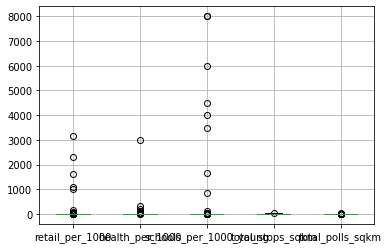

In [49]:
all_aggs_df[["retail_per_1000", "health_per_1000", "schools_per_1000_young", "total_stops_sqkm", "total_polls_sqkm"]].boxplot()
sns.boxplot(

Finding mean and standard deviation for all components of well-resourced score in order to later find Z scores. We do so exclusive of outliers, seeing how many are present.

In [41]:
sql = """
CREATE OR REPLACE VIEW metrics AS
SELECT 
    avg(retail_per_1000) as "mean_retail",
    stddev(retail_per_1000) as "sd_retail",
    avg(health_per_1000) as "mean_health",
    stddev(health_per_1000) as "sd_health",
    avg(total_stops) as "mean_stops",
    stddev(total_stops) as "sd_stops",
    avg(total_polls) as "mean_polls",
    stddev(total_polls) as "sd_polls",
    avg(schools_per_1000_young) as "mean_schools",
    stddev(schools_per_1000_young) as  "sd_schools"
FROM
    all_aggs;
    
SELECT *
FROM metrics;
"""

query(conn, sql)

,mean_retail,sd_retail,mean_health,sd_health,mean_stops,sd_stops,mean_polls,sd_polls,mean_schools,sd_schools
0,31.467613,230.411673,17.189256,156.252531,81.387097,45.943604,4.300283,4.123853,101.943144,755.167601


Finally we calculate our z scores, and overall well-resourced score for each sa2 code. We employ score normalisation using the sigmoid function.

In [42]:
sql = """
CREATE OR REPLACE VIEW base_scores as
SELECT 
    sa2_code,
    (retail_per_1000 - mean_retail) / sd_retail 
        as "retail_z",
    (health_per_1000 - mean_health) / sd_health 
        as "health_z",
    (total_stops - mean_stops) / sd_stops 
        as "stops_z",
    (total_polls - mean_polls) / sd_polls 
        as "polls_z",
    (schools_per_1000_young - mean_schools) / sd_schools 
        as "schools_z",
    ((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((total_stops - mean_stops) / sd_stops) +
        ((total_polls - mean_polls) / sd_polls) +
        ((schools_per_1000_young - mean_schools) / sd_schools) 
        as "base_sum_z",
    1 / (1 + EXP(-1 * 
        (((retail_per_1000 - mean_retail) / sd_retail) + 
        ((health_per_1000 - mean_health) / sd_health) + 
        ((total_stops - mean_stops) / sd_stops) +
        ((total_polls - mean_polls) / sd_polls) +
        ((schools_per_1000_young - mean_schools) / sd_schools)))) 
        as "base_score"
FROM
    all_aggs CROSS JOIN metrics;
    
SELECT *
FROM base_scores
LIMIT 10;
"""

query(conn, sql)

,sa2_code,retail_z,health_z,stops_z,polls_z,schools_z,sum_z,score
0,102011028,-0.110635,-0.047115,-0.356679,-0.557800,-0.131248,-1.203476,0.230857
1,102011029,-0.116544,-0.075844,0.709846,-0.557800,-0.131243,-0.171584,0.457209
2,102011030,-0.091781,-0.052049,0.296296,0.654659,-0.099167,0.707957,0.669950
3,102011031,-0.094352,-0.021813,1.493416,0.412167,-0.127970,1.661448,0.840432
4,102011032,-0.101194,-0.020064,2.385814,0.654659,-0.130746,2.788469,0.942050
5,102011033,-0.120591,-0.089390,-1.031419,-0.557800,-0.132319,-1.931518,0.126583
6,102011034,-0.114382,-0.063025,-0.051957,-0.072816,-0.130525,-0.432706,0.393480
7,102011035,-0.126915,-0.088650,-0.487273,-0.800291,-0.130279,-1.633408,0.163364
8,102011036,-0.121291,-0.090585,-0.530805,-0.800291,-0.128079,-1.671052,0.158284
9,102011037,-0.122049,-0.074968,0.035106,-0.557800,-0.131489,-0.851200,0.299181


#### OLD MASSIVE JOIN

In [43]:
# this isnt ideal as it will duplicate each row for each catchment, then this set of rows for each stop, then again for each poll
'''
sql="""
CREATE OR REPLACE VIEW joined AS
SELECT *
FROM regions r LEFT JOIN business b USING (sa2_code)
               LEFT JOIN population p USING (sa2_code)
               JOIN catchments c ON ST_INTERSECTS(r.geometry, c.geometry)
               JOIN stops s ON ST_CONTAINS(r.geometry, s.geometry)
               JOIN polls q ON ST_CONTAINS(r.geometry, q.geometry)
GROUP BY ;
               
SELECT *
FROM joined
LIMIT 10;
""" 

query(conn, sql)
'''

'\nsql="""\nCREATE OR REPLACE VIEW joined AS\nSELECT *\nFROM regions r LEFT JOIN business b USING (sa2_code)\n               LEFT JOIN population p USING (sa2_code)\n               JOIN catchments c ON ST_INTERSECTS(r.geometry, c.geometry)\n               JOIN stops s ON ST_CONTAINS(r.geometry, s.geometry)\n               JOIN polls q ON ST_CONTAINS(r.geometry, q.geometry)\nGROUP BY ;\n               \nSELECT *\nFROM joined\nLIMIT 10;\n""" \n\nquery(conn, sql)\n'

## Task 3: Extending the "Well-Resourced" Score & Score Analysis

In [44]:
income = pd.read_csv("Income.csv")
print(income.shape)
print(income.columns)


# Filtering for only the entries with income data in greater Sydney
income = income[(income["earners"]!="np") & (income["median_age"]!="np")
        & (income["median_income"]!="np") & (income["mean_income"]!="np")]
income = income.loc[income["sa2_code"].isin(regions["sa2_code"])]

# Correcting datatypes
income = income.astype({"earners":"int64", "median_age":"int64", "median_income":"int64", "mean_income":"int64"})
print(income.dtypes)

# Removing unnecessary columns
income.drop("sa2_name", axis=1, inplace=True)

(576, 6)
Index(['sa2_code', 'sa2_name', 'earners', 'median_age', 'median_income',
       'mean_income'],
      dtype='object')
sa2_code          int64
sa2_name         object
earners           int64
median_age        int64
median_income     int64
mean_income       int64
dtype: object


After cleaning the dataset, we can finally export it to the database:

In [38]:
# Adding to postgresql database
sql = """
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER PRIMARY KEY REFERENCES regions (sa2_code),
    earners INTEGER NOT NULL,
    median_age INTEGER NOT NULL,
    median_income INTEGER NOT NULL,
    mean_income INTEGER NOT NULL
);"""
conn.execute(sql);

income.to_sql("income", conn, schema="sa2", if_exists="append", index=False)


query(conn, "SELECT * FROM income LIMIT 5;")

,sa2_code,earners,median_age,median_income,mean_income
0,102011028,4788,47,52450,71977
1,102011029,6647,49,48724,64621
2,102011030,2919,49,46228,61545
3,102011031,7962,48,48292,67162
4,102011032,11439,42,51999,62478


This dataset contains an explicit sa2_code column, so we can directly join it with the sa2_code column in the regions dataset when performing the analysis.

#### Correlations
We will now see if there is any correlation between our z scores and median income of each region

In [48]:
sql = '''
CREATE TABLE final_scores AS SELECT * FROM scores; 
'''

query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [43]:
To extend the coverage of the score and allow additional analysis, we will import the following four datsets into our database.